In [1]:
import h2o
import operator
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import numpy as np
from matplotlib import pyplot as plt
import warnings
import sys
sys.path.append('../plot/')
from ice import ice, ice_plot
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators import H2OGradientBoostingEstimator
warnings.filterwarnings("ignore")
from h2o.estimators.random_forest import H2ORandomForestEstimator
from IPython.display import Image, display
from h2o.backend import H2OLocalServer
import subprocess
import shutil
%matplotlib inline

# Abstract
## Prototype Building
Our goal is to build a prototype which suitable for different types of datasets, this prototype is able to interpret models and data in a more understandable way. We provide several models to fit the dataset with the help of H2O libraries, including linear regression, logistic regression, decision tree and gradient boosting model. After model training, we demonstrate the interpretability by three different plots, they are variable importance, partial dependence plot and individual conditional expectation (ICE). Finally, we compare our model by matrix AUC and select the best model. Based on the interpretable plots from the best model, we are able to interpret the whole dataset.

# 1 Data Preparation

## 1.1 H2O Initialization

In [2]:
pct_memory=4
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

27


In [3]:
h2o.init(strict_version_check=False,max_mem_size=min_mem_size)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,1 day 2 hours 3 mins
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.2
H2O cluster version age:,10 days
H2O cluster name:,H2O_from_python_mandy_jpex0n
H2O cluster total nodes:,1
H2O cluster free memory:,25.54 Gb
H2O cluster total cores:,12
H2O cluster allowed cores:,12
H2O cluster status:,"locked, healthy"


## 1.2 Data Import & Parse

In [4]:
data_path = "../data/AmazonReviews.Small.csv"

# Load data into H2O
reviews = h2o.import_file(data_path)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [5]:
reviews.shape

(55554, 10)

In [6]:
reviews.head(3)

ProductId,UserId,Summary,Score,HelpfulnessDenominator,Id,ProfileName,HelpfulnessNumerator,Time,Text
B00141QYSQ,A1YS02UZZGRDCT,Do Not Buy,1,2,41471,Evan Eberhardt,2,1.34836e+09,"These are made in China (do not buy ANY pet food from China). Dogswell has been using propylene glycol to soften their treats (what are they thinkng?). Do not purchase or support this company in any way until they clean up their act. And for whatever reason Amazon doesn't allow returns of this item, so I had to toss mine out. Bad business all around on this one."
B0089SPEO2,A3JOYNYL458QHP,Less lemon and less zing,3,0,28582,coleridge,0,1.32391e+09,"Everything is ok, except it just isn't as good as it is in the bags. Just considerably more bland -- less lemon and less zing. Boring."
B001PMCDK2,A14TTMM0Z03Y2W,my cat goes crazy for these!,5,0,389965,Lindsay S. Bradford,0,1.3106e+09,"Best cat treat ever. There isn't anything comparable to the love my cat has for these treats, he snubs away any other kind now.I know he likes to manipulate me with his cattiness but these treats are my way of manipulating him to come sit on my lap and have some chill time. :)"


In [7]:
reviews['PositiveReview']=(reviews['Score']>=reviews['Score'].mean()[0]).ifelse('1','0')

In [8]:
reviews['PositiveReview'].table()

PositiveReview,Count
0,20106
1,35448


In [9]:
# Find the 80th quantile of time in the dataset
time_split = reviews["Time"].quantile(prob = [0.8])[1]
reviews["Train"] = (reviews["Time"] < time_split).ifelse("Yes", "No")

In [10]:
reviews['Train'].table()

Train,Count
No,11152
Yes,44402


In [11]:
train = reviews[reviews["Train"] == "Yes"]
test = reviews[reviews["Train"] == "No"]

## 1.3 Tokenize Words in Review

In [12]:
data_path = "../data/stopwords.csv"
STOP_WORDS = pd.read_csv(data_path, header=0)

In [13]:
STOP_WORDS.head()

,STOP_WORD
0,all
1,just
2,being
3,over
4,both


In [14]:
STOP_WORDS = list(STOP_WORDS['STOP_WORD'])

In [15]:
def tokenize(sentences, stop_word = STOP_WORDS):
    tokenized = sentences.tokenize("\\W+")
    tokenized_lower = tokenized.tolower()
    tokenized_filtered = tokenized_lower[(tokenized_lower.nchar() >= 2) | (tokenized_lower.isna()),:]
    tokenized_words = tokenized_filtered[tokenized_filtered.grep("[0-9]",invert=True,output_logical=True),:]
    tokenized_words = tokenized_words[(tokenized_words.isna()) | (~ tokenized_words.isin(STOP_WORDS)),:]
    return tokenized_words

In [16]:
# Break reviews into sequence of words
words = tokenize(reviews["Text"])

In [17]:
words.head()

C1
made
china
buy
pet
food
china
dogswell
using
propylene
glycol


## 1.4 Word2Vec Model

In [18]:
# Train Word2Vec Model
from h2o.estimators.word2vec import H2OWord2vecEstimator

w2v_model = H2OWord2vecEstimator(vec_size = 100, model_id = "w2v_amazon.hex")
w2v_model.train(training_frame=words)

models_path='../data'
h2o.save_model(w2v_model, path = models_path, force = True)

word2vec Model Build progress: |██████████████████████████████████████████| 100%


'/Users/mandy/Desktop/AI-Addin/data/w2v_amazon.hex'

In [19]:
# Sanity check - find synonyms for the word 'coffee'
w2v_model.find_synonyms("coffee", count = 5)

OrderedDict([('coffees', 0.7854233384132385),
             ('coffe', 0.7737622261047363),
             ('espresso', 0.7585617899894714),
             ('expresso', 0.7354114651679993),
             ('starbucks', 0.7260045409202576)])

In [20]:
# Sanity check - find synonyms for the word 'stale'
w2v_model.find_synonyms("stale", count = 5)

OrderedDict([('rancid', 0.6490443348884583),
             ('unedible', 0.6352749466896057),
             ('moldy', 0.6281526684761047),
             ('tasteless', 0.6241437196731567),
             ('tastless', 0.6231432557106018)])

In [21]:
# Calculate a vector for each review
review_vecs = w2v_model.transform(words, aggregate_method = "AVERAGE")
review_vecs

C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100
-0.00595513,0.188775,-0.0955057,-0.0753901,-0.0516168,-0.132675,0.0739875,-0.331696,0.190749,0.105761,-0.0562264,-0.0852027,0.296952,0.252802,-0.0635712,-0.0960593,0.061056,0.137746,-0.0186261,-0.0737836,-0.00538329,-0.18333,0.0484449,-0.0100591,0.10204,0.046592,0.0763898,-0.00572439,0.0351087,0.0462552,0.0544662,0.0621042,0.246037,-0.0863014,0.15249,-0.0941028,0.109358,-0.037614,-0.0411647,-0.150919,-0.0780024,-0.135649,-0.0242806,-0.0788803,-0.096298,0.0743402,-0.0460691,-0.146098,-0.0510593,-0.130496,0.118261,0.182891,0.0538447,-0.0137801,0.0741921,0.045408,0.0646674,0.133419,-0.0681497,0.00326586,-0.102485,0.0980313,0.0634861,-0.0992263,0.011278,0.0313968,-0.14025,-0.0737611,0.22456,-0.0100218,0.128841,-0.0803825,-0.00933717,0.0307881,-0.0420892,0.0463378,0.0512726,-0.0453849,0.0411827,-0.0269672,-0.272663,0.0446375,0.19068,0.160655,-0.0387367,-0.00748892,-0.0134898,-0.017386,-0.0550577,0.0512861,-0.0517981,0.133549,-0.0846468,0.0855768,0.0692748,-0.0421099,-0.033756,0.0237784,0.0831265,0.00794462
-0.0279089,0.125378,-0.0514916,0.247229,-0.155423,-0.0917946,0.0421103,-0.114098,-0.0236199,0.0744081,0.0533772,0.0652677,0.0324977,0.213496,0.113823,-0.131662,0.0503544,-0.00938812,-0.0560856,-0.0388709,0.00577034,-0.0272678,-0.047186,0.0580106,0.117653,0.0371851,0.0842167,0.0686686,0.0210045,-0.0465491,0.0639981,0.175792,0.277514,-0.0890254,0.0803218,0.134774,-0.0748535,-0.121024,-0.0614738,-0.0505653,0.00425927,0.01388,0.0243058,-0.130535,0.0709062,-0.0289777,0.0112402,0.065214,-0.135561,0.0496734,0.0675319,-0.0141326,0.185228,0.0487917,0.0801375,0.112699,0.00986692,0.10992,0.00560527,0.0456054,-0.0420284,0.365002,-0.110479,-0.109147,0.110398,0.0759429,0.00491245,-0.115247,0.155033,-0.00171167,0.0574843,-0.239682,0.0105647,0.05771,0.114169,0.164355,0.0394318,-0.146957,-0.0435431,-0.0675023,-0.16196,0.0718397,-0.11416,0.0494918,0.110682,-0.0501953,0.00536579,-0.170598,-0.0574283,0.0217728,-0.0845453,0.12979,-0.146552,0.159655,0.212794,0.0300939,-0.0140044,0.02916,0.143311,0.174912
0.0410092,0.00610173,-0.123784,0.128426,-0.0749437,-0.0693189,-0.025936,-0.282144,0.0410002,0.272217,-0.0525788,0.035746,0.066476,0.247745,-0.00377105,-0.0965954,0.255118,0.00350246,-0.0288831,-0.0807395,-0.0503751,-0.117927,0.0183842,-0.0606956,0.147259,0.018423,0.0140828,-0.00645153,-0.0195978,0.0990412,0.00728413,0.0839868,0.280747,-0.0876042,-0.0402257,-0.073929,0.0904504,-0.100017,0.00303649,-0.0259092,-0.176867,-0.0112962,-0.0261441,-0.0367177,0.0140157,0.0635297,0.103155,-0.126161,-0.196642,0.0142026,0.110058,0.128262,0.0533872,-0.051987,-0.00836969,0.0536857,-0.0483921,-0.0070495,-0.0728023,0.0733609,-0.0708347,0.0763289,0.0479198,-0.0792605,-0.08345,0.0396328,-0.112844,-0.154366,0.177891,-0.106111,0.114726,-0.164126,-0.0410952,0.0999544,-0.0190369,0.0919059,0.000966199,-0.0198594,0.0219507,-0.00849392,-0.125705,-0.0500592,0.136037,0.192031,-0.0851506,-0.0124529,0.0531875,-0.0273405,-0.134539,0.0620502,-0.0464124,0.0367823,-0.16625,0.209788,0.0773825,0.061043,-0.0541673,-0.081087,0.0728605,0.157803
0.0736087,0.0203575,-0.00820706,0.0486519,-0.0450143,-0.128303,0.0581946,-0.161612,0.0524164,0.0445975,-0.0671324,0.0510151,0.0664004,0.17516,0.0336253,-0.13994,0.270356,0.0254438,-0.0203349,-0.0543712,0.00794082,-0.164791,0.0139251,-0.030061,0.0569426,0.144691,0.0337863,0.112989,0.0170513,-0.0277229,0.0386401,0.0601789,0.351146,-0.102813,0.0199267,-0.0456868,0.2444,-0.0465237,0.00500521,-0.152869,-0.0706612,-0.0393468,-0.0192498,-0.0599551,-0.0274521,-0.00759518,0.0663789,-0.00510472,-0.0587898,0.0555321,0.0190526,0.0196803,-0.0118344,0.0959515,0.119664,0.0159272,

In [22]:
# Add aggregated word embeddings 
ext_reviews = reviews.cbind(review_vecs)

In [23]:
ext_reviews.head(3)

ProductId,UserId,Summary,Score,HelpfulnessDenominator,Id,ProfileName,HelpfulnessNumerator,Time,Text,PositiveReview,Train,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100
B00141QYSQ,A1YS02UZZGRDCT,Do Not Buy,1,2,41471,Evan Eberhardt,2,1.34836e+09,"These are made in China (do not buy ANY pet food from China). Dogswell has been using propylene glycol to soften their treats (what are they thinkng?). Do not purchase or support this company in any way until they clean up their act. And for whatever reason Amazon doesn't allow returns of this item, so I had to toss mine out. Bad business all around on this one.",0,No,-0.00595513,0.188775,-0.0955057,-0.0753901,-0.0516168,-0.132675,0.0739875,-0.331696,0.190749,0.105761,-0.0562264,-0.0852027,0.296952,0.252802,-0.0635712,-0.0960593,0.061056,0.137746,-0.0186261,-0.0737836,-0.00538329,-0.18333,0.0484449,-0.0100591,0.10204,0.046592,0.0763898,-0.00572439,0.0351087,0.0462552,0.0544662,0.0621042,0.246037,-0.0863014,0.15249,-0.0941028,0.109358,-0.037614,-0.0411647,-0.150919,-0.0780024,-0.135649,-0.0242806,-0.0788803,-0.096298,0.0743402,-0.0460691,-0.146098,-0.0510593,-0.130496,0.118261,0.182891,0.0538447,-0.0137801,0.0741921,0.045408,0.0646674,0.133419,-0.0681497,0.00326586,-0.102485,0.0980313,0.0634861,-0.0992263,0.011278,0.0313968,-0.14025,-0.0737611,0.22456,-0.0100218,0.128841,-0.0803825,-0.00933717,0.0307881,-0.0420892,0.0463378,0.0512726,-0.0453849,0.0411827,-0.0269672,-0.272663,0.0446375,0.19068,0.160655,-0.0387367,-0.00748892,-0.0134898,-0.017386,-0.0550577,0.0512861,-0.0517981,0.133549,-0.0846468,0.0855768,0.0692748,-0.0421099,-0.033756,0.0237784,0.0831265,0.00794462
B0089SPEO2,A3JOYNYL458QHP,Less lemon and less zing,3,0,28582,coleridge,0,1.32391e+09,"Everything is ok, except it just isn't as good as it is in the bags. Just considerably more bland -- less lemon and less zing. Boring.",0,Yes,-0.0279089,0.125378,-0.0514916,0.247229,-0.155423,-0.0917946,0.0421103,-0.114098,-0.0236199,0.0744081,0.0533772,0.0652677,0.0324977,0.213496,0.113823,-0.131662,0.0503544,-0.00938812,-0.0560856,-0.0388709,0.00577034,-0.0272678,-0.047186,0.0580106,0.117653,0.0371851,0.0842167,0.0686686,0.0210045,-0.0465491,0.0639981,0.175792,0.277514,-0.0890254,0.0803218,0.134774,-0.0748535,-0.121024,-0.0614738,-0.0505653,0.00425927,0.01388,0.0243058,-0.130535,0.0709062,-0.0289777,0.0112402,0.065214,-0.135561,0.0496734,0.0675319,-0.0141326,0.185228,0.0487917,0.0801375,0.112699,0.00986692,0.10992,0.00560527,0.0456054,-0.0420284,0.365002,-0.110479,-0.109147,0.110398,0.0759429,0.00491245,-0.115247,0.155033,-0.00171167,0.0574843,-0.239682,0.0105647,0.05771,0.114169,0.164355,0.0394318,-0.146957,-0.0435431,-0.0675023,-0.16196,0.0718397,-0.11416,0.0494918,0.110682,-0.0501953,0.00536579,-0.170598,-0.0574283,0.0217728,-0.0845453,0.12979,-0.146552,0.159655,0.212794,0.0300939,-0.0140044,0.02916,0.143311,0.174912
B001PMCDK2,A14TTMM0Z03Y2W,my cat goes crazy for these!,5,0,389965,Lindsay S. Bradford,0,1.3106e+09,"Best cat treat ever. There isn't anything comparable to the love my cat has for these treats, he snubs away any other kind now.I know he likes to manipulate me with his cattiness but these treats are my way of manipulating him to come sit on my lap and have some chill time. :)",1,Yes,0.0410092,0.00610173,-0.123784,0.128426,-0.0749437,-0.0693189,-0.025936,-0.282144,0.0410002,0.272217,-0.0525788,0.035746,0.066476,0.247745,-0.00377105,-0.0965954,0.255118,0.00350246,-0.0288831,-0.0807395,-0.0503751,-0.117927,0.0183842,-0.0606956,0.147259,0.018423,0.0140828,-0.00645153,-0.0195978,0.0990412,0.00728413,0.0839868,0.280747,-0.0876042,-0.0402257,-0.073929,0.0904504,-0.100017,0.00303649,-0.0259092,

## 1.5 Add Summary Column

In [24]:
# Break summaries into sequence of word.
summary_words = tokenize(reviews['Summary'].ascharacter())

In [25]:
summary_vecs = w2v_model.transform(summary_words, aggregate_method='AVERAGE')
summary_vecs.names = ['summary_'+ s for s in summary_vecs.names]

ext_reviews_new = ext_reviews.cbind(summary_vecs)

In [26]:
ext_reviews_new.head(3)

ProductId,UserId,Summary,Score,HelpfulnessDenominator,Id,ProfileName,HelpfulnessNumerator,Time,Text,PositiveReview,Train,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100,summary_C1,summary_C2,summary_C3,summary_C4,summary_C5,summary_C6,summary_C7,summary_C8,summary_C9,summary_C10,summary_C11,summary_C12,summary_C13,summary_C14,summary_C15,summary_C16,summary_C17,summary_C18,summary_C19,summary_C20,summary_C21,summary_C22,summary_C23,summary_C24,summary_C25,summary_C26,summary_C27,summary_C28,summary_C29,summary_C30,summary_C31,summary_C32,summary_C33,summary_C34,summary_C35,summary_C36,summary_C37,summary_C38,summary_C39,summary_C40,summary_C41,summary_C42,summary_C43,summary_C44,summary_C45,summary_C46,summary_C47,summary_C48,summary_C49,summary_C50,summary_C51,summary_C52,summary_C53,summary_C54,summary_C55,summary_C56,summary_C57,summary_C58,summary_C59,summary_C60,summary_C61,summary_C62,summary_C63,summary_C64,summary_C65,summary_C66,summary_C67,summary_C68,summary_C69,summary_C70,summary_C71,summary_C72,summary_C73,summary_C74,summary_C75,summary_C76,summary_C77,summary_C78,summary_C79,summary_C80,summary_C81,summary_C82,summary_C83,summary_C84,summary_C85,summary_C86,summary_C87,summary_C88
B00141QYSQ,A1YS02UZZGRDCT,Do Not Buy,1,2,41471,Evan Eberhardt,2,1.34836e+09,"These are made in China (do not buy ANY pet food from China). Dogswell has been using propylene glycol to soften their treats (what are they thinkng?). Do not purchase or support this company in any way until they clean up their act. And for whatever reason Amazon doesn't allow returns of this item, so I had to toss mine out. Bad business all around on this one.",0,No,-0.00595513,0.188775,-0.0955057,-0.0753901,-0.0516168,-0.132675,0.0739875,-0.331696,0.190749,0.105761,-0.0562264,-0.0852027,0.296952,0.252802,-0.0635712,-0.0960593,0.061056,0.137746,-0.0186261,-0.0737836,-0.00538329,-0.18333,0.0484449,-0.0100591,0.10204,0.046592,0.0763898,-0.00572439,0.0351087,0.0462552,0.0544662,0.0621042,0.246037,-0.0863014,0.15249,-0.0941028,0.109358,-0.037614,-0.0411647,-0.150919,-0.0780024,-0.135649,-0.0242806,-0.0788803,-0.096298,0.0743402,-0.0460691,-0.146098,-0.0510593,-0.130496,0.118261,0.182891,0.0538447,-0.0137801,0.0741921,0.045408,0.0646674,0.133419,-0.0681497,0.00326586,-0.102485,0.0980313,0.0634861,-0.0992263,0.011278,0.0313968,-0.14025,-0.0737611,0.22456,-0.0100218,0.128841,-0.0803825,-0.00933717,0.0307881,-0.0420892,0.0463378,0.0512726,-0.0453849,0.0411827,-0.0269672,-0.272663,0.0446375,0.19068,0.160655,-0.0387367,-0.00748892,-0.0134898,-0.017386,-0.0550577,0.0512861,-0.0517981,0.133549,-0.0846468,0.0855768,0.0692748,-0.0421099,-0.033756,0.0237784,0.0831265,0.00794462,-0.130137,0.280003,-0.35236,-0.0246027,-0.0161076,0.0792112,0.204889,-0.557999,0.258583,0.303658,0.0396854,-0.00944702,0.0664348,0.343833,-0.0010784,-0.256408,0.00471677,0.232451,0.124086,0.0308446,0.0517971,0.0143376,-0.13751,0.0171038,-0.00553991,-0.101305,0.0554408,0.0168484,-0.0968795,0.178484,0.0678175,0.267305,0.38963,-0.0703171,0.135593,-0.200004,0.0719251,-0.0935606,-0.0191885,-0.146816,0.0236615,-0.014024,-0.0733795,-0.423104,-0.156332,-0.12213,0.315631,-0.0717768,-0.0204778,-0.131391,-0.174991,0.142973,0.167967,-0.0117451,-0.0720414,-0.00841114,0.165682,0.306809,-0.259988,-0.0845798,0.0731062,0.03841,0.201564,-0.185767,-0.036988,-0.121714,-0.0177772,-0.0973615,0.281626,0.0813684,0.111734,-0.331569,0.0736507,0.0880911,-0.0437503,-0.174357,0.0810106,-0.0206904,0.0405273,-0.0751429,0.131225,0.47235,-0.0749708,-0.0965327,-0.0442405,0.149981,-0.025484,-0.0956554
B0089SPEO2,A3JOYNYL458QHP,Less lemon and less zing,3,0,28582,coleridge,0,1.32391e+09,"Everythin

In [27]:
ext_train_new = ext_reviews_new[ext_reviews_new["Train"] == "Yes"]
ext_test_new = ext_reviews_new[ext_reviews_new["Train"] == "No"]

In [28]:
ext_test_simple = ext_test_new.drop([2, 6, 9])

In [29]:
predictors = ['ProductId', 'UserId', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time'] + summary_vecs.names + review_vecs.names 
response = 'PositiveReview'

## 1.6 Leaderboard

H2O’s AutoML can be used for automating the machine learning workflow, which includes automatic training and tuning of many models within a user-specified time-limit. With the help of Auto ML, we are able to find the “best” model from building large number of models without any prior knowledge.

In [37]:
run_time=1500

In [38]:
# Set up AutoML
aml = H2OAutoML()

In [39]:
aml.train(x=predictors,y=response,training_frame=ext_train_new)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [35]:
print(aml.leaderboard)

model_id,auc,logloss,mean_per_class_error,rmse,mse
XGBoost_1_AutoML_20190426_155539,0.896382,0.379217,0.204441,0.343743,0.118159


# 2 Training Models

On the aspect of training model, we take the advantage of H2O library and run the leaderboard of models which can fit the dataset best. Beside some advanced models such as GBM and XGBoost, we also train some basic models like Generalized Linear Model and Logistic Regression. These models may seem easy to train and use, but very useful and powerful regards fitting various types of datasets.

In order to compare our models in a same standard, we will use the score of AUC to do so. Since our target is binomial variable, ROC is one of the best matrixes to evaluate the accuracy. And the score of AUC would allow us to compare the models easily and accurately.

## 2.1 Generalized Linear Model

### 2.1.1 Train & Fit Model

In [32]:
# Initialize
local_glm_plus = H2OGeneralizedLinearEstimator(family='binomial', model_id='glm', lambda_search=True)
# train 
local_glm_plus.train(x=predictors, y=response, training_frame=ext_train_new)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [35]:
local_glm_plus.algo

'glm'

### 2.1.2 Interpretability

#### Variable Importance

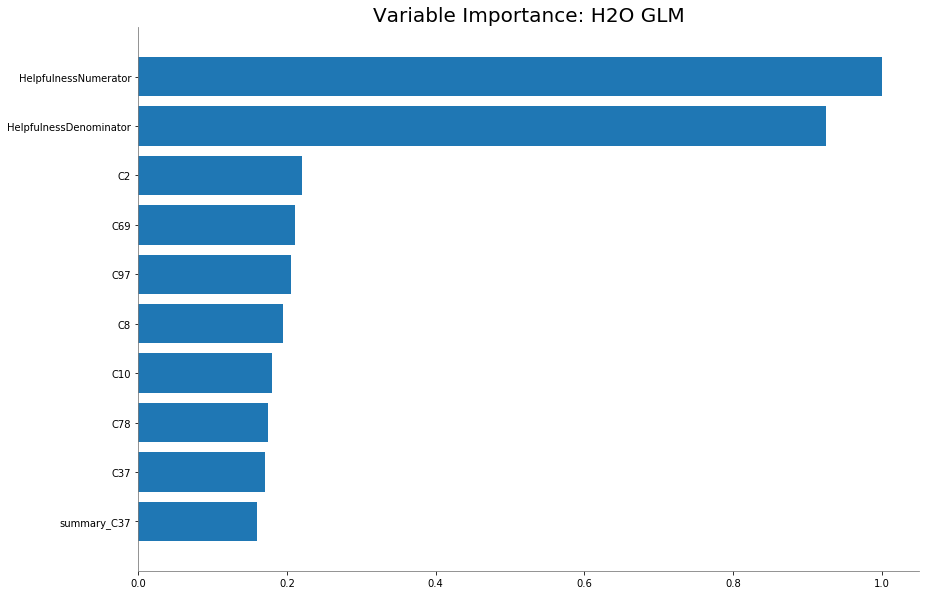

In [33]:
local_glm_plus.varimp_plot()

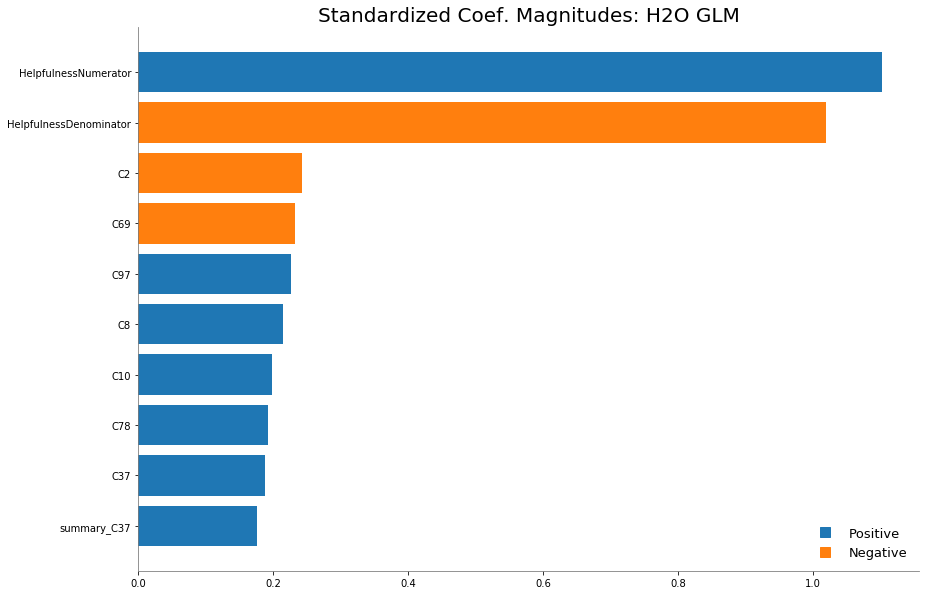

In [37]:
local_glm_plus.std_coef_plot(10)

We can get that the feature "HelpfulnessNumerator" is the most important.

#### Partial Dependence Plot (PDP)

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


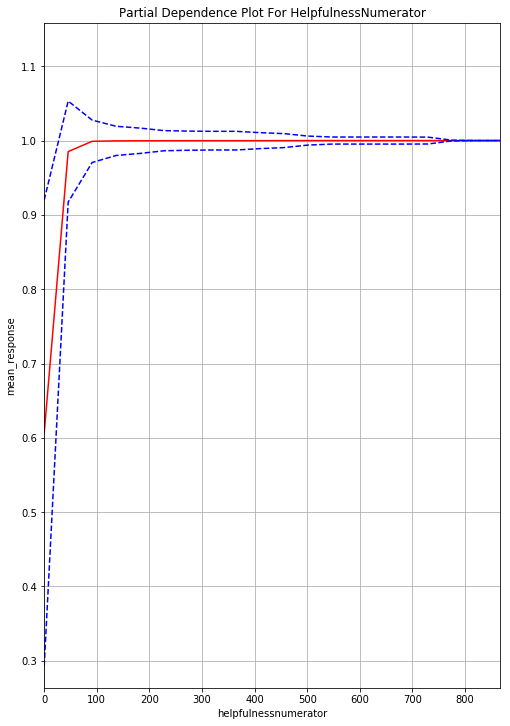

In [32]:
pdp_local_linear_plus = local_glm_plus.partial_plot(data = ext_train_new, cols = ["HelpfulnessNumerator"])

PDP for above model shows that the positive reviews always have a large "HelpfulnessNumerator"

#### Individual Conditional Expectation (ICE)

In [33]:
HelpfulnessNumerator_ice_df = ice(data=ext_test_simple, column='HelpfulnessNumerator', model=local_glm_plus)

Parse progress: |█████████████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


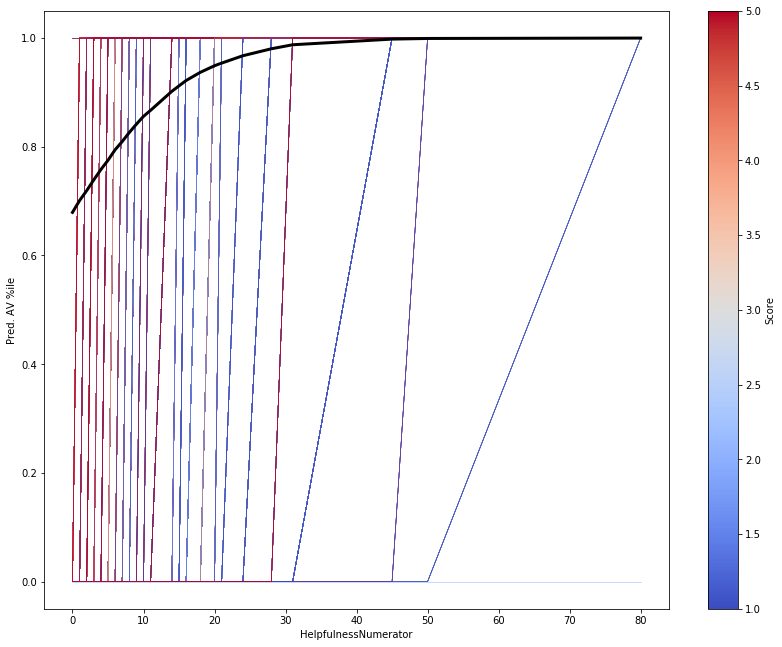

In [34]:
ice_plot(HelpfulnessNumerator_ice_df, linewidth=0.5, color_by='Score', cmap='coolwarm',
        plot_pdp=True, pdp_kwargs={'c': 'k', 'linewidth': 3})
vals = HelpfulnessNumerator_ice_df.columns.get_level_values('Score').values
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vals.min(), vmax=vals.max()))
sm._A = []
plt.colorbar(sm, label='Score')
plt.ylabel('Pred. AV %ile')
plt.xlabel('HelpfulnessNumerator');

We can get the reviews always be positive review when it's "HelpfulnessNumerator" is bigger than 30.

### 2.1.3 Matrix

In [38]:
print('\nLocal GLM Coefficients:')
for c_name, c_val in sorted(local_glm_plus.coef().items(), key=operator.itemgetter(1)):
    if c_val != 0.0:
        print('%s %s' % (str(c_name + ':').ljust(25), c_val))


Local GLM Coefficients:
C69:                      -3.4490114884767866
C65:                      -2.9082815260403128
C38:                      -2.3795689014985513
C2:                       -2.3558169900334334
C80:                      -2.340427771651155
C45:                      -2.246221706178425
C62:                      -2.134268232937816
C34:                      -2.092936842891942
C76:                      -1.938610748433551
C16:                      -1.747702369853479
C56:                      -1.6994613252029256
C44:                      -1.5054055276148761
C33:                      -1.3947488259551748
C79:                      -1.3639487018490204
C88:                      -1.2626091296533497
C83:                      -1.2403847254557072
C11:                      -1.221933575522876
C21:                      -1.111698897380542
C75:                      -1.068728732357223
C95:                      -1.0576384991051644
C92:                      -1.0444065074732864
C19:              

In [36]:
local_glm_plus.r2(train=True, valid=True)

{'train': 0.43586093201921394, 'valid': None}

In [37]:
local_glm_plus.auc()

0.878084460437871

In [38]:
local_glm_plus.confusion_matrix()

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46252907719125724: 


,0,1,Error,Rate
0,10240.0,5654.0,0.3557,(5654.0/15894.0)
1,2320.0,26188.0,0.0814,(2320.0/28508.0)
Total,12560.0,31842.0,0.1796,(7974.0/44402.0)


## 2.2 Logistic Regression

### 2.2.1 Train & Fit Model

In [40]:
glm_logistic_plus_summary = H2OGeneralizedLinearEstimator(family = "binomial")
glm_logistic_plus_summary.train(x=predictors, 
                               y= response, 
                               training_frame = ext_train_new, 
                               validation_frame = ext_test_new, 
                               model_id="glm_logistic")

glm Model Build progress: |███████████████████████████████████████████████| 100%


### 2.2.2 Interpretability

#### Variable Importance

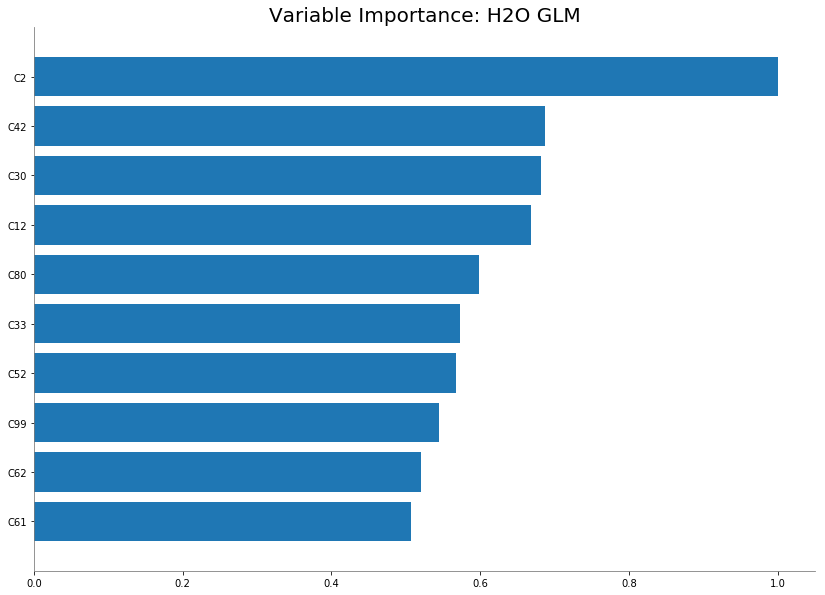

In [41]:
glm_logistic_plus_summary.varimp_plot()

We can get that the feature "C2" is the most important.

#### Partial Dependence Plot (PDP)

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


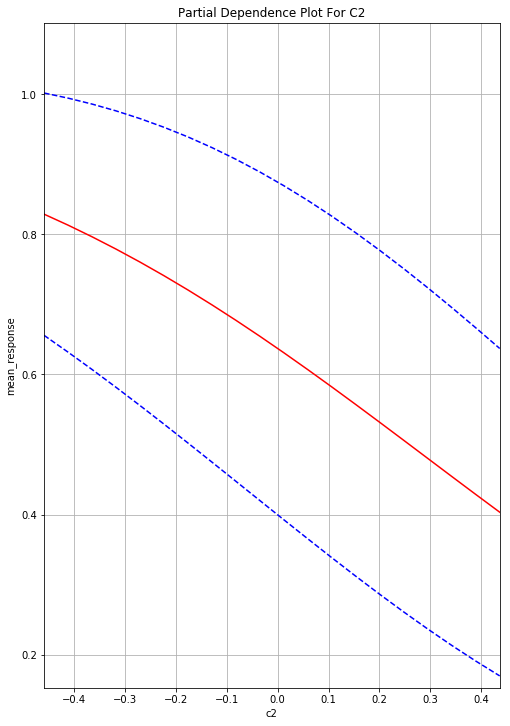

In [43]:
pdp_word_vecs = glm_logistic_plus_summary.partial_plot(data = ext_train_new, cols = ["C2"])

PDP for above model shows that the positive reviews always have a large "C2"

#### Individual Conditional Expectation (ICE)

In [44]:
ext_test_simple_lice = h2o.H2OFrame(ext_test_simple.as_data_frame().iloc[::25])

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [45]:
ext_test_simple_lice.shape

(447, 209)

In [49]:
C2_ice_df = ice(data=ext_test_simple_lice, column='C2', model=glm_logistic_plus_summary)

Parse progress: |█████████████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


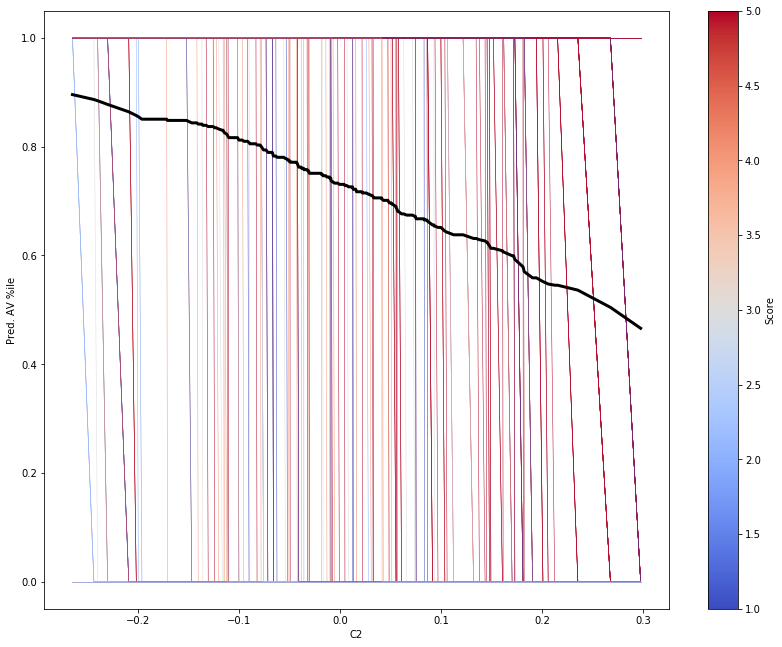

In [50]:
ice_plot(C2_ice_df, linewidth=0.5, color_by='Score', cmap='coolwarm',
        plot_pdp=True, pdp_kwargs={'c': 'k', 'linewidth': 3})
vals = C2_ice_df.columns.get_level_values('Score').values
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vals.min(), vmax=vals.max()))
sm._A = []
plt.colorbar(sm, label='Score')
plt.ylabel('Pred. AV %ile')
plt.xlabel('C2');

We can get the reviews always be positive review when it's "C2" is bigger.

### 2.2.3 Matrix

In [51]:
print("With Summary and Review Embeddings AUC: " + str(round(glm_logistic_plus_summary.auc(valid = True), 3)))

With Summary and Review Embeddings AUC: 0.858


In [52]:
glm_logistic_plus_summary.confusion_matrix(valid = True)

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.490824729673773: 


,0,1,Error,Rate
0,2608.0,1604.0,0.3808,(1604.0/4212.0)
1,623.0,6317.0,0.0898,(623.0/6940.0)
Total,3231.0,7921.0,0.1997,(2227.0/11152.0)


In [53]:
glm_logistic_plus_summary.confusion_matrix(valid = True)

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.490824729673773: 


,0,1,Error,Rate
0,2608.0,1604.0,0.3808,(1604.0/4212.0)
1,623.0,6317.0,0.0898,(623.0/6940.0)
Total,3231.0,7921.0,0.1997,(2227.0/11152.0)


## 2.3 Gradient Boosting I

In [30]:
# define a function to remove all the intermediate file
def cleanPath(projectName, model, zipFile):
    path = '../plot/decisionTree/' + projectName + '/' + model
    if not os.path.exists(path):
        os.makedirs(path)            
        print ("---  new folder...  ---")
        print (path)
        print ("-------   OK  ---------")
    else:
        print ("-------   OK  ---------")
    
    shutil.move('../data/'+zipFile, path + '/'+model+'_hex.zip')
    shutil.move('dt_surrogate_mojo.gv', path + '/dt_surrogate_mojo.gv')
    shutil.move('dt_surrogate_mojo.png', path + '/dt_surrogate_mojo.png')

### 2.3.1 Train & Fit Model

In [31]:
# initialize single tree surrogate model
model_id = 'dt_surrogate_mojo'

# train single tree surrogate model
surrogate = H2OGradientBoostingEstimator(ntrees=1,
                                         sample_rate=1,
                                         col_sample_rate=1,
                                         max_depth=3,
                                         seed=12345,
                                         model_id=model_id)

_ = surrogate.train(x=predictors, y=response, training_frame=ext_train_new)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [32]:
# persist MOJO (compiled, representation of trained model)
# from which to generate plot of surrogate
mojo_path = surrogate.download_mojo(path='../data')

print(surrogate)
print('Generated MOJO path:\n', mojo_path)

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  dt_surrogate_mojo


ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.22283494487815628
RMSE: 0.4720539639470855
LogLoss: 0.637147742179252
Mean Per-Class Error: 0.32711511054478026
AUC: 0.7270365896510715
pr_auc: 0.44675705644398295
Gini: 0.4540731793021431
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6206703685664695: 


,0,1,Error,Rate
0,2769.0,13125.0,0.8258,(13125.0/15894.0)
1,679.0,27829.0,0.0238,(679.0/28508.0)
Total,3448.0,40954.0,0.3109,(13804.0/44402.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.6206704,0.8012726,6.0
max f2,0.5964188,0.8996806,7.0
max f0point5,0.6405236,0.7633043,3.0
max accuracy,0.6312366,0.7044502,4.0
max precision,0.6616343,0.8404787,0.0
max recall,0.5964188,1.0,7.0
max specificity,0.6616343,0.8574305,0.0
max absolute_mcc,0.6405236,0.3379394,3.0
max min_per_class_accuracy,0.6454858,0.6718888,2.0
max mean_per_class_accuracy,0.6454858,0.6728849,2.0


Gains/Lift Table: Avg response rate: 64.20 %, avg score: 64.18 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.3199180,0.6616343,1.3090689,1.3090689,0.8404787,0.6616343,0.8404787,0.6616343,0.4187947,0.4187947,30.9068873,30.9068873
,2,0.4497770,0.6516270,1.1501826,1.2631955,0.7384669,0.6516270,0.8110260,0.6587450,0.1493616,0.5681563,15.0182622,26.3195451
,3,0.5501104,0.6454858,1.0537348,1.2249924,0.6765432,0.6454858,0.7864980,0.6563267,0.1057247,0.6738810,5.3734797,22.4992421
,4,0.6287555,0.6405236,0.9763540,1.1938926,0.6268614,0.6405236,0.7665306,0.6543500,0.0767855,0.7506665,-2.3646002,19.3892579
,5,0.7921040,0.6312366,0.8327716,1.1194218,0.5346753,0.6312366,0.7187171,0.6495835,0.1360320,0.8866985,-16.7228393,11.9421839
,6,0.8264493,0.6246120,0.7312720,1.1032912,0.4695082,0.6246120,0.7083606,0.6485458,0.0251158,0.9118142,-26.8727973,10.3291240
,7,0.9223458,0.6206704,0.6712220,1.0583689,0.4309535,0.6206704,0.6795185,0.6456476,0.0643679,0.9761821,-32.8777982,5.8368870
,8,1.0,0.5964188,0.3067173,1.0,0.1969258,0.5964188,0.6420432,0.6418247,0.0238179,1.0,-69.3282681,0.0



Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
,2019-04-26 22:33:36,0.002 sec,0.0,0.4793994,0.6522336,0.5,0.0,1.0,0.3579568
,2019-04-26 22:33:36,0.140 sec,1.0,0.4720540,0.6371477,0.7270366,0.4467571,1.3090689,0.3108869


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
summary_C91,832.9461670,1.0,0.5138620
summary_C38,238.6433411,0.2865051,0.1472241
C91,207.0442505,0.2485686,0.1277300
summary_C50,172.6138458,0.2072329,0.1064891
summary_C36,91.1429977,0.1094224,0.0562280
---,---,---,---
summary_C96,0.0,0.0,0.0
summary_C97,0.0,0.0,0.0
summary_C98,0.0,0.0,0.0
summary_C99,0.0,0.0,0.0



See the whole table with table.as_data_frame()

Generated MOJO path:
 /Users/mandy/Desktop/AI-Addin/data/dt_surrogate_mojo.zip


In [33]:
details = False # print more info on tree, details = True
title = 'Amazon Reviews Decision Tree Surrogate'

hs = H2OLocalServer()
h2o_jar_path = hs._find_jar()
print('Discovered H2O jar path:\n', h2o_jar_path)

gv_file_name = model_id + '.gv'
gv_args = str('-cp ' + h2o_jar_path +
              ' hex.genmodel.tools.PrintMojo --tree 0 -i '
              + mojo_path + ' -o ').split()
gv_args.insert(0, 'java')
gv_args.append(gv_file_name)

if details:
    gv_args.append('--detail')

if title is not None:
    gv_args = gv_args + ['--title', title]
    
print()
print('Calling external process ...')
print(' '.join(gv_args))
    
_ = subprocess.call(gv_args)

Discovered H2O jar path:
 /anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar

Calling external process ...
java -cp /anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i /Users/mandy/Desktop/AI-Addin/data/dt_surrogate_mojo.zip -o dt_surrogate_mojo.gv --title Amazon Reviews Decision Tree Surrogate


In [34]:
png_file_name = model_id + '.png'
png_args = str('dot -Tpng ' + gv_file_name + ' -o ' + png_file_name)
png_args = png_args.split()

print('Calling external process ...')
print(' '.join(png_args))

_ = subprocess.call(png_args)

Calling external process ...
dot -Tpng dt_surrogate_mojo.gv -o dt_surrogate_mojo.png


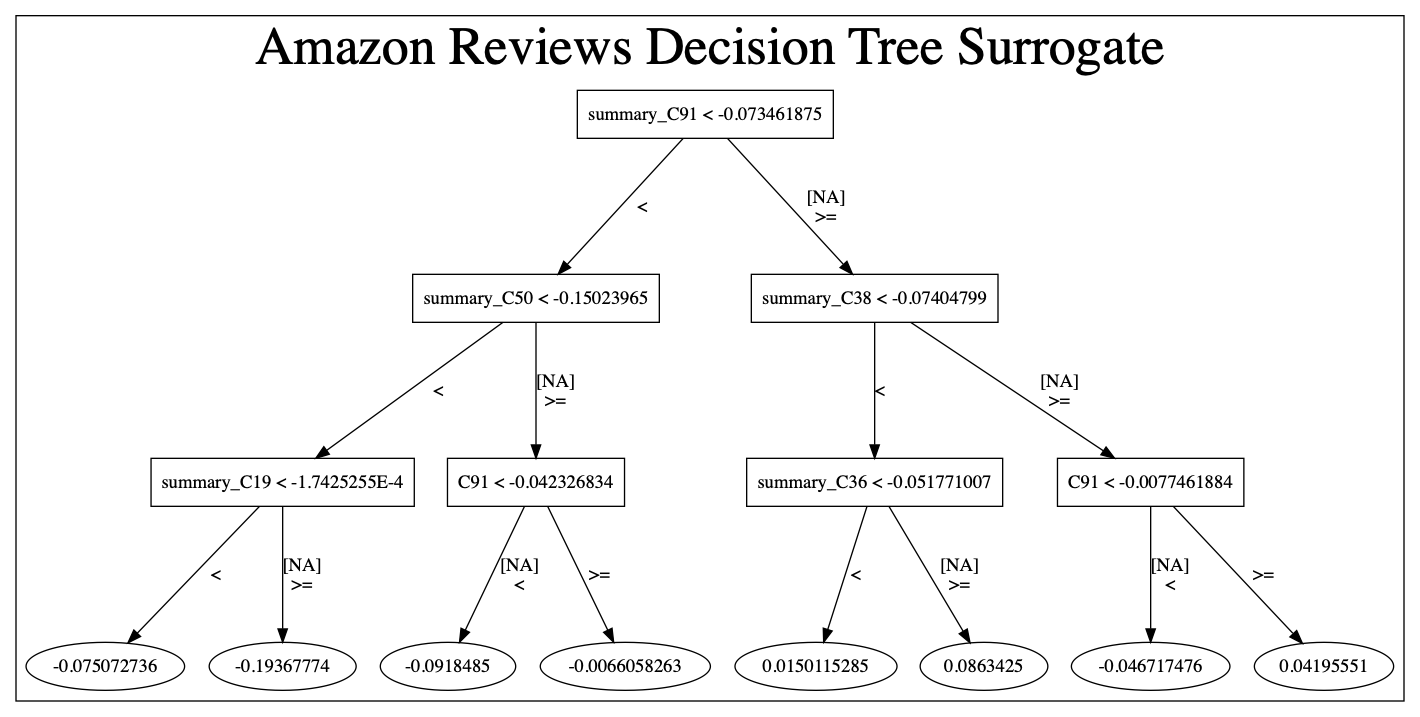

In [35]:
display(Image((png_file_name)))

In [36]:
cleanPath('amazon','dt_surrogate', 'dt_surrogate_mojo.zip')

-------   OK  ---------


### 2.3.2 Interpretability

#### Variable Importance

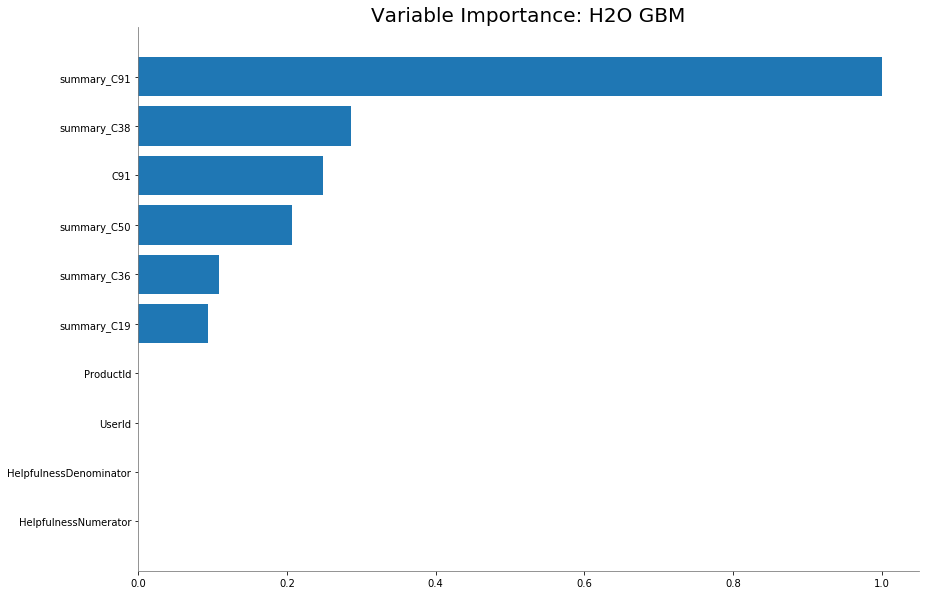

In [37]:
surrogate.varimp_plot()

We can get that the feature "summary_C91" is the most important.

#### Partial Dependence Plot (PDP)

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


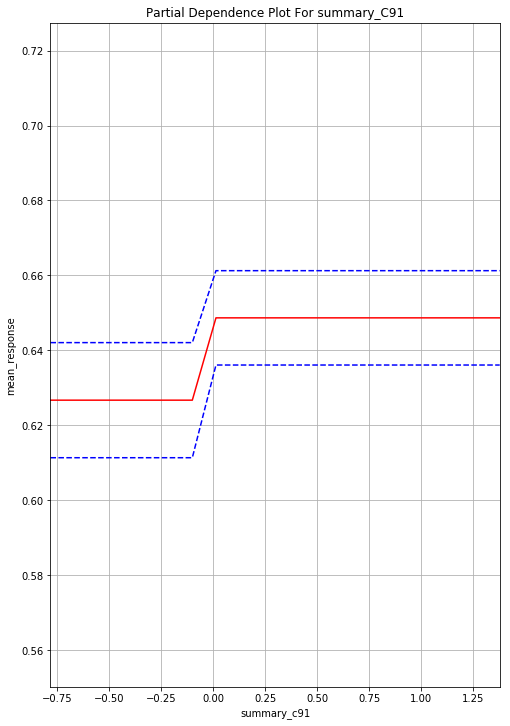

In [45]:
pdp_word_vecs = surrogate.partial_plot(data = ext_train_new, cols = ["summary_C91"])

PDP for above model shows that the positive reviews always have a large "summary_C91"

#### Individual Conditional Expectation (ICE)

In [39]:
ext_test_simple_dice = h2o.H2OFrame(ext_test_simple.as_data_frame().iloc[::20])

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [40]:
ext_test_simple_dice.shape

(558, 209)

In [46]:
C91_ice_df = ice(data=ext_test_simple_dice, column='summary_C91', model=surrogate)

Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


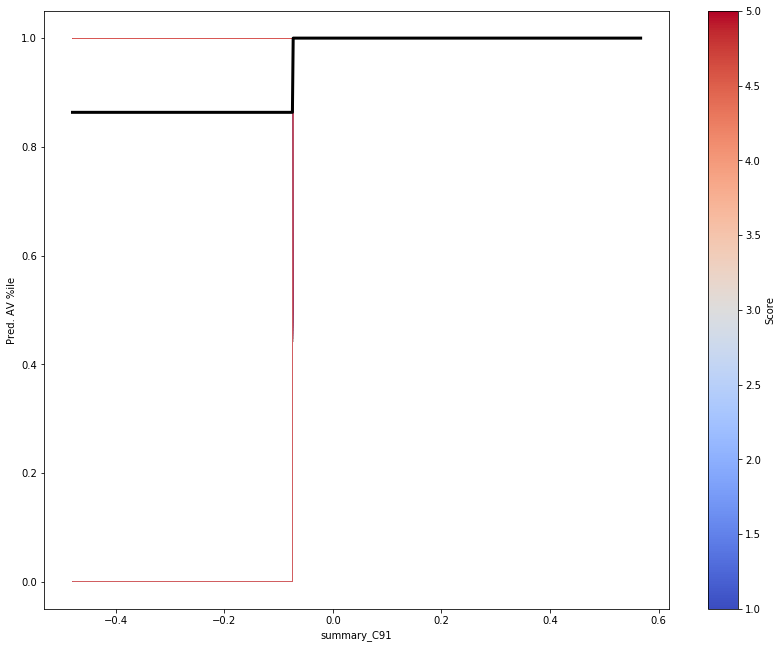

In [49]:
ice_plot(C91_ice_df, linewidth=0.5, color_by='Score', cmap='coolwarm',
        plot_pdp=True, pdp_kwargs={'c': 'k', 'linewidth': 3})
vals = C91_ice_df.columns.get_level_values('Score').values
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vals.min(), vmax=vals.max()))
sm._A = []
plt.colorbar(sm, label='Score')
plt.ylabel('Pred. AV %ile')
plt.xlabel('summary_C91');

We can get the reviews always be positive review when it's "summary_C91" is bigger than 0.

### 2.3.3 Matrix

In [50]:
print(surrogate)

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  dt_surrogate_mojo


ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.22283494487815628
RMSE: 0.4720539639470855
LogLoss: 0.637147742179252
Mean Per-Class Error: 0.32711511054478026
AUC: 0.7270365896510715
pr_auc: 0.44675705644398295
Gini: 0.4540731793021431
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6206703685664695: 


,0,1,Error,Rate
0,2769.0,13125.0,0.8258,(13125.0/15894.0)
1,679.0,27829.0,0.0238,(679.0/28508.0)
Total,3448.0,40954.0,0.3109,(13804.0/44402.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.6206704,0.8012726,6.0
max f2,0.5964188,0.8996806,7.0
max f0point5,0.6405236,0.7633043,3.0
max accuracy,0.6312366,0.7044502,4.0
max precision,0.6616343,0.8404787,0.0
max recall,0.5964188,1.0,7.0
max specificity,0.6616343,0.8574305,0.0
max absolute_mcc,0.6405236,0.3379394,3.0
max min_per_class_accuracy,0.6454858,0.6718888,2.0
max mean_per_class_accuracy,0.6454858,0.6728849,2.0


Gains/Lift Table: Avg response rate: 64.20 %, avg score: 64.18 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.3199180,0.6616343,1.3090689,1.3090689,0.8404787,0.6616343,0.8404787,0.6616343,0.4187947,0.4187947,30.9068873,30.9068873
,2,0.4497770,0.6516270,1.1501826,1.2631955,0.7384669,0.6516270,0.8110260,0.6587450,0.1493616,0.5681563,15.0182622,26.3195451
,3,0.5501104,0.6454858,1.0537348,1.2249924,0.6765432,0.6454858,0.7864980,0.6563267,0.1057247,0.6738810,5.3734797,22.4992421
,4,0.6287555,0.6405236,0.9763540,1.1938926,0.6268614,0.6405236,0.7665306,0.6543500,0.0767855,0.7506665,-2.3646002,19.3892579
,5,0.7921040,0.6312366,0.8327716,1.1194218,0.5346753,0.6312366,0.7187171,0.6495835,0.1360320,0.8866985,-16.7228393,11.9421839
,6,0.8264493,0.6246120,0.7312720,1.1032912,0.4695082,0.6246120,0.7083606,0.6485458,0.0251158,0.9118142,-26.8727973,10.3291240
,7,0.9223458,0.6206704,0.6712220,1.0583689,0.4309535,0.6206704,0.6795185,0.6456476,0.0643679,0.9761821,-32.8777982,5.8368870
,8,1.0,0.5964188,0.3067173,1.0,0.1969258,0.5964188,0.6420432,0.6418247,0.0238179,1.0,-69.3282681,0.0



Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
,2019-04-26 22:33:36,0.002 sec,0.0,0.4793994,0.6522336,0.5,0.0,1.0,0.3579568
,2019-04-26 22:33:36,0.140 sec,1.0,0.4720540,0.6371477,0.7270366,0.4467571,1.3090689,0.3108869


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
summary_C91,832.9461670,1.0,0.5138620
summary_C38,238.6433411,0.2865051,0.1472241
C91,207.0442505,0.2485686,0.1277300
summary_C50,172.6138458,0.2072329,0.1064891
summary_C36,91.1429977,0.1094224,0.0562280
---,---,---,---
summary_C96,0.0,0.0,0.0
summary_C97,0.0,0.0,0.0
summary_C98,0.0,0.0,0.0
summary_C99,0.0,0.0,0.0



See the whole table with table.as_data_frame()



## 2.4 Gradient Boosting II

### 2.4.1 Train & Fit Model

In [51]:
gbm = H2OGradientBoostingEstimator(stopping_metric = "AUC",
                                           stopping_tolerance = 0.001,
                                           stopping_rounds = 5, 
                                           score_tree_interval = 10, 
                                           model_id = 'gbm.hex')
gbm.train(x = predictors, 
                   y = response,
                  training_frame = ext_train_new,
                  validation_frame = ext_test_new)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [52]:
# persist MOJO (compiled, representation of trained model)
# from which to generate plot of surrogate
mojo_path = gbm.download_mojo(path='../data')

print(gbm)
print('Generated MOJO path:\n', mojo_path)

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  gbm.hex


ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.12614425226595558
RMSE: 0.3551679212231245
LogLoss: 0.40676881117103053
Mean Per-Class Error: 0.18196574166134916
AUC: 0.8960594470145266
pr_auc: 0.9292120838891273
Gini: 0.7921188940290531
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5139196911098128: 


,0,1,Error,Rate
0,10595.0,5299.0,0.3334,(5299.0/15894.0)
1,2134.0,26374.0,0.0749,(2134.0/28508.0)
Total,12729.0,31673.0,0.1674,(7433.0/44402.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.5139197,0.8764893,221.0
max f2,0.3245853,0.9270016,290.0
max f0point5,0.6701795,0.8737059,156.0
max accuracy,0.5488178,0.8347147,207.0
max precision,0.9616110,1.0,0.0
max recall,0.0805261,1.0,382.0
max specificity,0.9616110,1.0,0.0
max absolute_mcc,0.5643666,0.6336479,201.0
max min_per_class_accuracy,0.6547357,0.8156658,163.0
max mean_per_class_accuracy,0.6365791,0.8180343,171.0


Gains/Lift Table: Avg response rate: 64.20 %, avg score: 64.19 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100221,0.9464967,1.5365273,1.5365273,0.9865169,0.9522044,0.9865169,0.9522044,0.0153992,0.0153992,53.6527338,53.6527338
,2,0.0200216,0.9407718,1.5505118,1.5435117,0.9954955,0.9435140,0.9910011,0.9478641,0.0155044,0.0309036,55.0511821,54.3511714
,3,0.0300212,0.9351844,1.5399880,1.5423380,0.9887387,0.9377828,0.9902476,0.9445062,0.0153992,0.0463028,53.9987985,54.2338019
,4,0.0400207,0.9307175,1.5224483,1.5373684,0.9774775,0.9330100,0.9870568,0.9416338,0.0152238,0.0615266,52.2448259,53.7368377
,5,0.0500203,0.9265719,1.5364800,1.5371908,0.9864865,0.9286452,0.9869428,0.9390372,0.0153641,0.0768907,53.6480040,53.7190790
,6,0.1000180,0.9092714,1.5161340,1.5266647,0.9734234,0.9176878,0.9801846,0.9283649,0.0758033,0.1526940,51.6133957,52.6664744
,7,0.1500158,0.8920840,1.4866672,1.5133342,0.9545045,0.9007341,0.9716259,0.9191560,0.0743300,0.2270240,48.6667217,51.3334236
,8,0.2000135,0.8753253,1.4859656,1.5064929,0.9540541,0.8837532,0.9672334,0.9103063,0.0742949,0.3013189,48.5965627,50.6492855
,9,0.3000090,0.8362286,1.4431687,1.4853864,0.9265766,0.8561660,0.9536822,0.8922609,0.1443104,0.4456293,44.3168695,48.5386386
,10,0.4000045,0.7880928,1.3849368,1.4602754,0.8891892,0.8130787,0.9375598,0.8724665,0.1384874,0.5841167,38.4936803,46.0275404




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.14838261146538342
RMSE: 0.3852046358305977
LogLoss: 0.46206878333077234
Mean Per-Class Error: 0.22382447843542952
AUC: 0.8510707365534456
pr_auc: 0.8851983416683897
Gini: 0.7021414731068911
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45573174148933604: 


,0,1,Error,Rate
0,2356.0,1856.0,0.4406,(1856.0/4212.0)
1,501.0,6439.0,0.0722,(501.0/6940.0)
Total,2857.0,8295.0,0.2114,(2357.0/11152.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.4557317,0.8452904,245.0
max f2,0.2603955,0.9122189,319.0
max f0point5,0.6449597,0.8339511,165.0
max accuracy,0.5113410,0.7950143,223.0
max precision,0.9616635,1.0,0.0
max recall,0.0819745,1.0,384.0
max specificity,0.9616635,1.0,0.0
max absolute_mcc,0.5503818,0.5540334,207.0
max min_per_class_accuracy,0.6474520,0.7737417,164.0
max mean_per_class_accuracy,0.6311550,0.7761755,172.0


Gains/Lift Table: Avg response rate: 62.23 %, avg score: 62.93 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100430,0.9448845,1.5638740,1.5638740,0.9732143,0.9514436,0.9732143,0.9514436,0.0157061,0.0157061,56.3874022,56.3874022
,2,0.0200861,0.9382292,1.4777892,1.5208316,0.9196429,0.9415268,0.9464286,0.9464852,0.0148415,0.0305476,47.7789214,52.0831618
,3,0.0300395,0.9326383,1.5200561,1.5205746,0.9459459,0.9352566,0.9462687,0.9427647,0.0151297,0.0456772,52.0056079,52.0574648
,4,0.0400825,0.9280561,1.4921367,1.5134493,0.9285714,0.9303233,0.9418345,0.9396474,0.0149856,0.0606628,49.2136682,51.3449252
,5,0.0500359,0.9239450,1.5490095,1.5205231,0.9639640,0.9261027,0.9462366,0.9369530,0.0154179,0.0760807,54.9009528,52.0523070
,6,0.1000717,0.9044522,1.5234028,1.5219630,0.9480287,0.9140703,0.9471326,0.9255116,0.0762248,0.1523055,52.3402849,52.1962960
,7,0.1500179,0.8860116,1.4713238,1.5051034,0.9156194,0.8953875,0.9366408,0.9154823,0.0734870,0.2257925,47.1323838,50.5103431
,8,0.2000538,0.8673043,1.4888455,1.5010371,0.9265233,0.8770449,0.9341103,0.9058686,0.0744957,0.3002882,48.8845506,50.1037128
,9,0.3000359,0.8228910,1.3864158,1.4628414,0.8627803,0.8451402,0.9103407,0.8856319,0.1386167,0.4389049,38.6415787,46.2841433
,10,0.4000179,0.7708042,1.3431804,1.4329329,0.8358744,0.7975202,0.8917283,0.8636089,0.1342939,0.5731988,34.3180367,43.2932873



Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
,2019-04-26 22:43:41,0.013 sec,0.0,0.4793994,0.6522336,0.5,0.0,1.0,0.3579568,0.4852110,0.6637626,0.5,0.0,1.0,0.3776901
,2019-04-26 22:43:45,3.284 sec,10.0,0.4189206,0.5334243,0.8286354,0.8764869,1.5113559,0.2259132,0.4268895,0.5483112,0.8139435,0.8537237,1.5701168,0.2470409
,2019-04-26 22:43:47,5.749 sec,20.0,0.3924643,0.4811391,0.8567712,0.9008837,1.5120269,0.2056889,0.4064777,0.5070885,0.8306879,0.8709206,1.5495266,0.2303623
,2019-04-26 22:43:48,7.121 sec,30.0,0.3757340,0.4478270,0.8748643,0.9144418,1.5190270,0.1870636,0.3957591,0.4846112,0.8413104,0.8789715,1.5064841,0.2217539
,2019-04-26 22:43:50,8.472 sec,40.0,0.3641674,0.4245862,0.8867264,0.9231605,1.5330273,0.1765461,0.3898512,0.4716987,0.8464615,0.8820409,1.5351791,0.2157461
,2019-04-26 22:43:51,9.471 sec,50.0,0.3551679,0.4067688,0.8960594,0.9292121,1.5365273,0.1674024,0.3852046,0.4620688,0.8510707,0.8851983,1.5638740,0.2113522


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
summary_C91,3989.3520508,1.0,0.1653926
C91,1764.0212402,0.4421824,0.0731337
C38,1471.5721436,0.3688750,0.0610092
summary_C38,1345.9884033,0.3373952,0.0558027
C50,1168.1760254,0.2928235,0.0484308
---,---,---,---
summary_C84,0.0,0.0,0.0
summary_C87,0.0,0.0,0.0
summary_C98,0.0,0.0,0.0
summary_C99,0.0,0.0,0.0



See the whole table with table.as_data_frame()

Generated MOJO path:
 /Users/mandy/Desktop/AI-Addin/data/gbm_hex.zip


In [53]:
details = False # print more info on tree, details = True
title = 'Yelp Reviews Decision Tree Surrogate'

hs = H2OLocalServer()
h2o_jar_path = hs._find_jar()
print('Discovered H2O jar path:\n', h2o_jar_path)

gv_file_name = model_id + '.gv'
gv_args = str('-cp ' + h2o_jar_path +
              ' hex.genmodel.tools.PrintMojo --tree 0 -i '
              + mojo_path + ' -o ').split()
gv_args.insert(0, 'java')
gv_args.append(gv_file_name)

if details:
    gv_args.append('--detail')

if title is not None:
    gv_args = gv_args + ['--title', title]
    
print()
print('Calling external process ...')
print(' '.join(gv_args))
    
_ = subprocess.call(gv_args)

Discovered H2O jar path:
 /anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar

Calling external process ...
java -cp /anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i /Users/mandy/Desktop/AI-Addin/data/gbm_hex.zip -o dt_surrogate_mojo.gv --title Yelp Reviews Decision Tree Surrogate


In [54]:
png_file_name = model_id + '.png'
png_args = str('dot -Tpng ' + gv_file_name + ' -o ' + png_file_name)
png_args = png_args.split()

print('Calling external process ...')
print(' '.join(png_args))

_ = subprocess.call(png_args)

Calling external process ...
dot -Tpng dt_surrogate_mojo.gv -o dt_surrogate_mojo.png


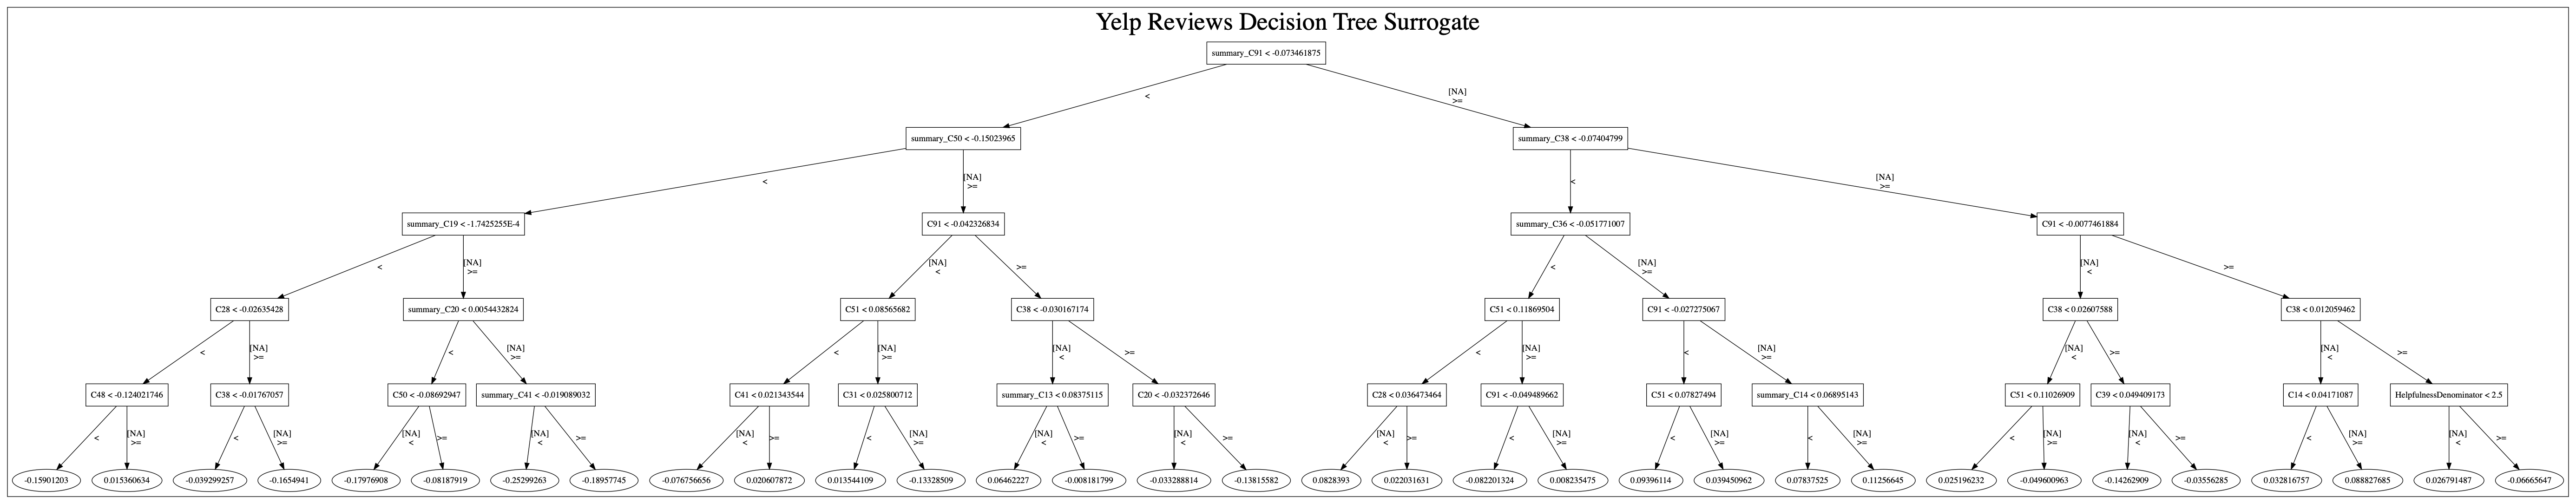

In [55]:
display(Image((png_file_name)))

In [56]:
cleanPath('amazon', 'gbm', 'gbm_hex.zip')

---  new folder...  ---
../plot/decisionTree/amazon/gbm
-------   OK  ---------


### 2.4.2 Interpretability

#### Variable Importance

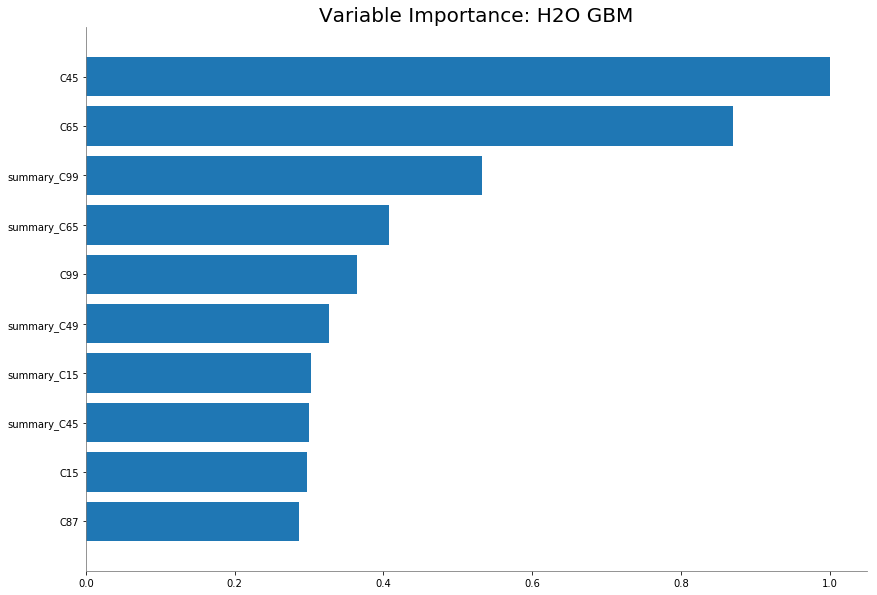

In [31]:
gbm.varimp_plot()

We can get that the feature "C45" is the most important.

#### Partial Dependence Plot (PDP)

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


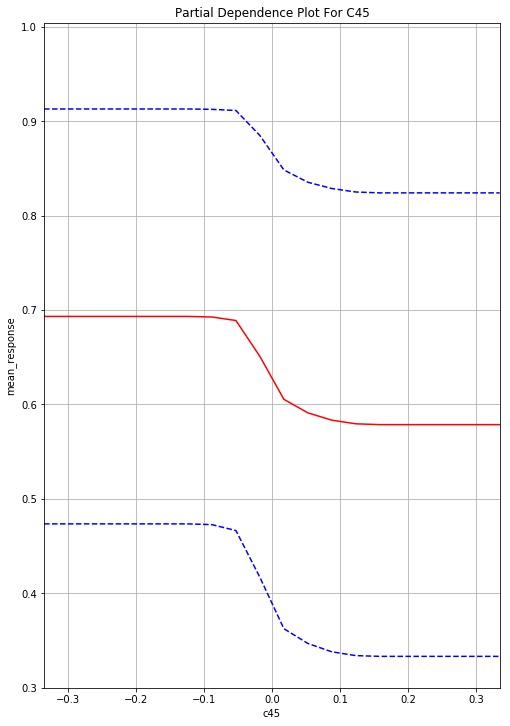

In [32]:
pdp_helpfulness = gbm.partial_plot(ext_train_new, cols = ['C45'])

PDP for above model shows that the positive reviews always have a large "C45".

#### Individual Conditional Expectation (ICE)

In [33]:
ext_test_simple_gice = ext_test_simple.sort('C45')

In [34]:
ext_test_simple_gices = h2o.H2OFrame(ext_test_simple_gice.as_data_frame().iloc[::15])

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [35]:
ext_test_simple_gices.shape

(558, 209)

In [36]:
C45_ice_df = ice(data=ext_test_simple_gices, column='C45', model=gbm)

Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


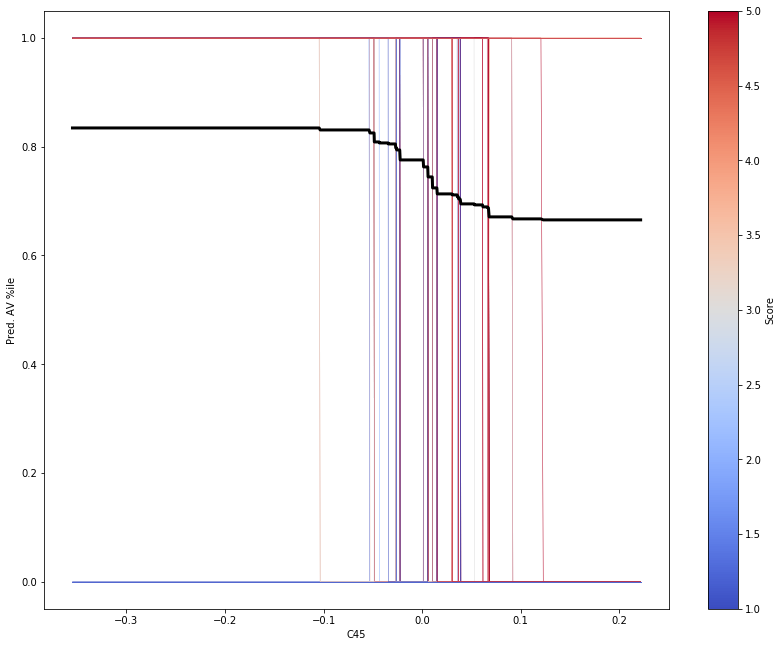

In [37]:
ice_plot(C45_ice_df, linewidth=0.5, color_by='Score', cmap='coolwarm',
        plot_pdp=True, pdp_kwargs={'c': 'k', 'linewidth': 3})
vals = C45_ice_df.columns.get_level_values('Score').values
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vals.min(), vmax=vals.max()))
sm._A = []
plt.colorbar(sm, label='Score')
plt.ylabel('Pred. AV %ile')
plt.xlabel('C45');

We can get the reviews always be positive review when it's "C45" is smaller than 0

### 2.4.3 Matrix

In [57]:
print("AUC on validation data: " + str(round(gbm.auc(valid = True), 3)))

AUC on validation data: 0.851


In [58]:
gbm.confusion_matrix(valid=True)

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45573174148933604: 


,0,1,Error,Rate
0,2356.0,1856.0,0.4406,(1856.0/4212.0)
1,501.0,6439.0,0.0722,(501.0/6940.0)
Total,2857.0,8295.0,0.2114,(2357.0/11152.0)


In [59]:
gbm.r2(train=True, valid=True)

{'train': 0.451126108588361, 'valid': 0.36869286353841046}

# 3 Conclusion

## 3.1 Models Comparison

| Model | AUC |
| --- | --- |
| Generalized Linear Model | 0.878 |
| Logistic Regression | 0.858 |
| Gradient Boosting Model I | 0.727 |
| Gradient Boosting Model II | 0.851 |

From the table above, we can easily select the model with the best performance based on matrix AUC score. In this case, **Generalized Linear Model** has the highest AUC score, which is .878. Thus, all interpretable explanation will based on model **Generalized Linear Model**.

## 3.2 Interpretability

This project is going to build an artificial intelligence software called AI-addin, which can automatically apply model interpretability algorithms to any data set that a user uploads for analysis. It can be applied in many fields, such as finance, commercial and medical[1].

In the work for our final project, we did interpretability explaintion for all models we built. Here we use Generalization Linear Model as an example(2.1.2). we plotted three plots:

- Variable Inportance: 
To choose which variable has the most important influences for our prediction. We can get that the feature "HelpfulnessNumerator" is the most important.

- Partial Dependence Plot (PDP):
The partial dependence plot (short PDP or PD plot) shows the marginal effect one or two features have on the predicted outcome of a machine learning model.[2] PDP for the first model shows that the positive reviews always have a large "HelpfulnessNumerator".

- Individual Conditional Expectation (ICE)
Individual Conditional Expectation (ICE) plots display one line per instance that shows how the instance’s prediction changes when a feature changes.[3] We can get the reviews always be positive review when it's "HelpfulnessNumerator" is bigger than 30.


# 4 Citations

* [1] https://github.com/skunkworksneu/Projects/blob/master/AI-addin.pdf
* [2] Friedman, Jerome H. “Greedy function approximation: A gradient boosting machine.” Annals of statistics (2001): 1189-1232.
* [3] https://christophm.github.io/interpretable-ml-book/ice.html

# 5 License

This work by AI-Addin project group is licensed under [The Creative Commons Attribution 3.0 License](https://creativecommons.org/licenses/by/3.0/us/)

In [42]:
# h2o.cluster().shutdown()

H2O session _sid_9208 closed.
